```yaml
title: "Jupyterの.ipynbファイルでAstroの記事を書く"
pubDate: 2025-11-27T20:00:00+09:00
ipynb_link_type: colab
lang: ja
```

[Jupyter](https://jupyter.org/) の `.ipynb` ファイルでこのブログ ([Astro](https://astro.build/) 製) の記事を書けるようにした.

ちなみに, この記事も ipynb ファイルで書かれている. たとえば, 以下のように Julia コードとその実行結果を記事に埋め込むことができる. また, ページ冒頭の執筆日付の横に, 本記事を「実行」することのできる Google Colab へのリンクがある.

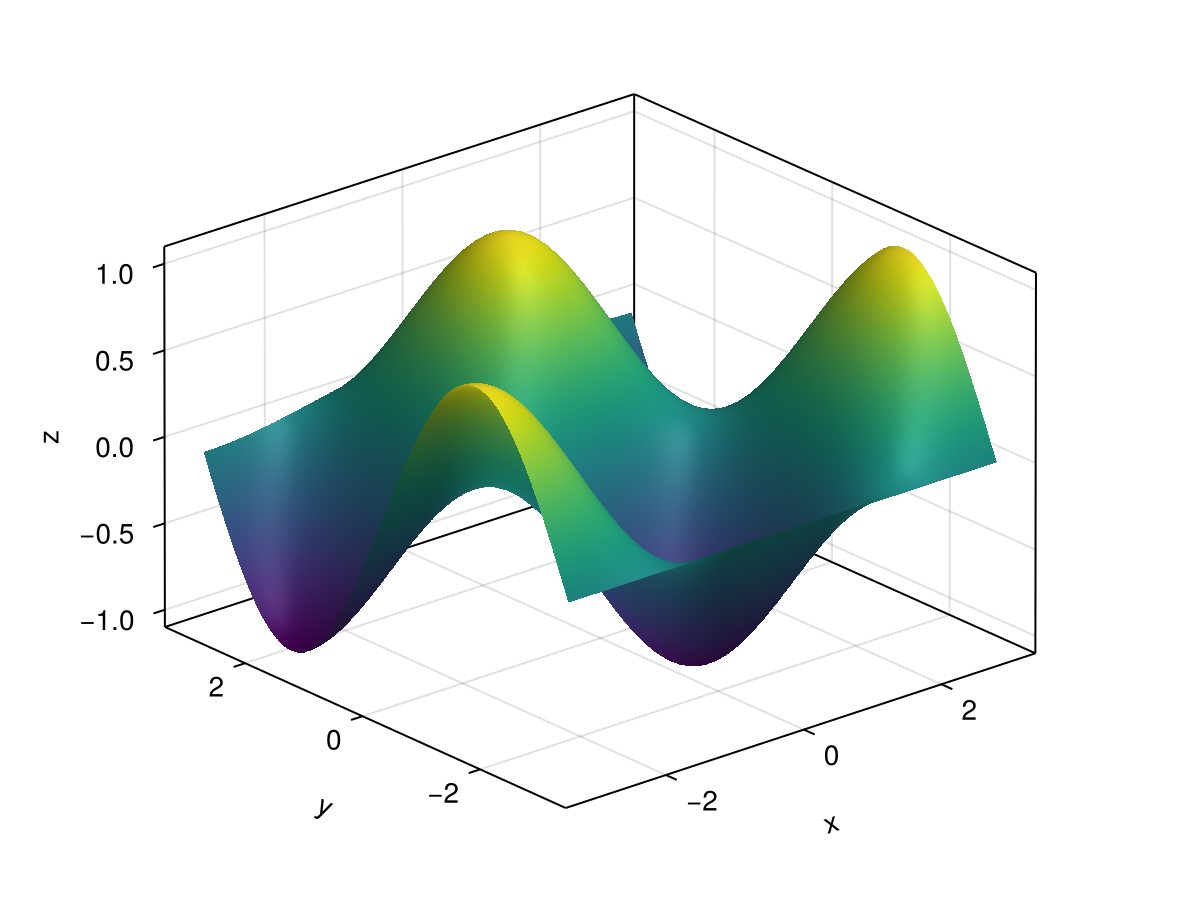

In [1]:
import Pkg; Pkg.add("CairoMakie"; io=devnull)
using CairoMakie
f(x, y) = cos(x)sin(y)
surface(-π:0.1:π, -π:0.1:π, f, axis=(type=Axis3,))

## 方針

前提として, 記事の管理には [Content Collections](https://docs.astro.build/en/guides/content-collections/) を使っている. `src/content` 以下にある拡張子 `.md` のファイルを適当にルーティングしてくれるものであり, これに `.ipynb` で書かれた記事の情報を噛ませるのは難しくはない. つまり, ビルド前に ipynb ファイルを Markdown に変換して `src/content` 以下に配置し, Content Collections の対象にすればよいのである[^policy].

[^policy]: 方針として, [@astro/mdx](https://github.com/withastro/astro/blob/main/packages/integrations/mdx/src/index.ts#L59) や [astro-typst](https://github.com/OverflowCat/astro-typst/blob/master/src/lib/integration.ts#L54) のように隠しAPI(!?)である `addPageExtension` と `addContentEntryType` で, そもそも記事のファイル形式として `".ipynb"` を追加する手も考えられる. 本当の意味で Astro で ipynb ファイルを扱うにはこういったものを書くべきであるが, 今回はそこまでしなかった. 余力があったら挑戦してみたい.

ipynb ファイルから Markdown への変換には [nbconvert](https://github.com/jupyter/nbconvert) を使う. たとえば, 以下のようなコマンドを実行すると, `post.ipynb` が Markdown に変換され, 標準出力に書き出される.

```sh
jupyter nbconvert --to markdown --stdout post.ipynb
```

ファイルに書き出すこともできるが, 標準出力で書き出した場合, もしコードセルの出力結果にPNG画像などがあった場合には base64 で Markdown 内に埋め込まれるため都合がよい.

これによって Markdown に変換した上, タイトルや執筆日付などの Frontmatter を整えて `post.ipynb.md`[^ipynbmd] として書き出せば, あとは Content Collections が他の `.md` ファイルと同様に扱ってくれる.

[^ipynbmd]: `.gitignore` で `*/**/*.ipynb.md` を指定することで, 中間生成物を Git の対象から除外することができる.

## 導入

以上の方針を元に, 適当に [Astro Integration](https://docs.astro.build/en/guides/integrations-guide/) のプラグインを作る. ビルドマシンに nbconvert がインストールされていることを前提としている.

```ts
// src/plugins/astro-ipynb.ts
import type { AstroIntegration } from "astro";
import glob from "fast-glob";
import path from "path";
import { execSync } from "child_process";
import fs from "fs";

export const ipynb = (): AstroIntegration => ({
  name: "ipynb",
  hooks: {
    // ビルド前に実行される hook
    "astro:config:setup": async ({ addWatchFile }) => {
      const ipynbFiles = await glob("src/content/**/*.ipynb");

      for (const file of ipynbFiles) {
        const ipynbPath = path.resolve(file);
        const ipynbBody = fs.readFileSync(ipynbPath, { encoding: "utf-8" });
        const ipynbObj = JSON.parse(ipynbBody);

        // 該当 ipynb ファイルを更新の監視対象に (`astro dev` の際にいい感じに再実行される)
        addWatchFile(ipynbPath);

        // 追加で ipynbObj の frontmatter をいい感じに整える処理など(後述)

        const mdPath = ipynbPath + ".md";
        try {
          // ipynb ファイルを md ファイルに変換
          const cmd = "jupyter nbconvert --to markdown --stdout --stdin";
          const mdBody = execSync(cmd, {
            input: JSON.stringify(ipynbObj),
            encoding: "utf-8",
          });

          // md ファイルの書き出し
          fs.writeFileSync(mdPath, mdBody);
        } catch (e) {
          // エラー処理が欲しければいい感じに
        }
      }
    },
  },
});
```

これを `src/plugins/astro-ipynb.ts` として追加したら, あとは `astro.config.mts` で読み込むだけである:

```ts
// astro.config.mts
import { ipynb } from "./src/plugins/astro-ipynb.ts";
... // 他の import

export default defineConfig({
  integrations: [
    ..., // 他の integration
    ipynb(),
  ],
});
```

以上で, ビルドのたびに `src/content` 以下に配置された ipynb ファイルに対応して md ファイルが生成され, Content Collections によって記事として追加されるはずである. ちなみに `astro dev` でも更新のたびに (時間はかかるが) 再生成されるので, 普通の Markdown による記事と同じような執筆体験を得ることができる.

## Tips

以上の導入だけで動くと思うが, 各サイトにあった細かい調整などは必要だと思う. 以下では, このブログで気になって調整したことなどをまとめる. このブログでの[最終的なプラグイン](https://github.com/xiupos/xiupos/blob/main/src/plugins/astro-ipynb.ts)も参考になれば嬉しい.

### Frontmatter

記事のタイトルや執筆日付などを指定する Frontmatter は, 上記の導入の場合は ipynb の冒頭に Markdown セルに平文で追加するだけである. つまり, 普通の Markdown 記事と同様に, 以下のような YAML を冒頭に書けばよい.

```yaml
---
title: "Jupyterで書かれた記事"
pubDate: "Nov 27 2025"
---
```

ただ, これだと Jupyter Notebook 上で表示が崩れてしまう. これを気にする場合は, たとえば YAML のコードブロックにして, Integration 側でそれを Frontmatter の形式に書き直すなどの処理をするといいと思う. また, 一度 YAML としてパースしておけば, 後述のように特別な処理を加えやすいのでおすすめである.

### slug

中間生成物の拡張子 `.ipynb.md` では, 最終的に生成される HTML の URL は `https://example.com/path/to/postipynb` になってしまう. それを避けるための方法の一つは, Frontmatter で `slug` を[設定する](https://docs.astro.build/ja/guides/content-collections/#defining-custom-ids)ことである.

```yaml
---
title: "Jupyterで書かれた記事"
pubDate: "Nov 27 2025"
slug: path/to/post
---
```

こうすれば `https://example.com/path/to/post` となる. 毎回設定するのは面倒であるなら, 上記の Frontmatter の処理の際に `ipynbDir` から前後をいい感じに削って `slug` を追加する処理を追加すればよい. 同様にして, 色々な項目を自動で追加することで, たとえば冒頭の Colab へのリンクのようなものを設定することができる.

### テンプレート

コードセルの実行結果に画像や HTML 要素がある場合, nbconvert で生成される Markdown ではそれらは直に置かれた HTML 要素になる. nbconvert の[テンプレートを指定する機能](https://test-nbconvertreturns.readthedocs.io/en/latest/customizing.html)を使うことで, そういった要素を適当な `div` で囲むことができる.

たとえば, テンプレートとして以下のような `src/templates/ipynb/conf.json` と `src/templates/ipynb/index.md.j2` を追加する:

```json
{
  "base_template": "markdown",
  "mimetypes": {
    "text/markdown": true
  }
}
```

```jinja
{# src/templates/ipynb/index.md.j2 #}
{% extends 'markdown/index.md.j2' %}

{% block data_html scoped %}
<div class="wrapper">
{{ super() }}
</div>
{% endblock data_html %}
```

その上で変換時に実行するコマンドでテンプレートを指定する:

```ts
const cmd = "jupyter nbconvert --template src/templates/ipynb ...";
```

こうすれば, 実行結果の HTML 要素は, 生成される Markdown では `<div class="wrapper"> ~ </div>` で囲まれる.

### CI/CD (GitHub Actions 等)

GitHub Actions 等でサイトをビルドする場合は, nbconvert を使えるようにするために追加の設定をする必要がある. [uv](https://github.com/astral-sh/uv) を使う場合は, [CI/CD に uv の環境セットアップを追加](https://docs.astral.sh/uv/guides/integration/)して, 変換時に実行するコマンドを以下のように書き換える.

```ts
const cmd = "uvx jupyter nbconvert ...";
```